TensorFlow inference from a Docker TF serving server.

Launch the server with docker-compose:
    
```bash
docker-compose up
```

Then execute the code below in order to get the model metadata and to run inference on some images.

In [1]:
import io
import json

import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from tqdm.auto import trange

In [4]:
# Get metadata about the model (sanity check)

host = "localhost"
port = 8501
model_name = "captchanet"
model_version = 1
root_url = f"http://{host}:{port}/v1/models/{model_name}/versions/{model_version}"

metadata_url = f"{root_url}/metadata"
req = requests.get(metadata_url)
metadata = json.loads(req.text)
metadata

{'model_spec': {'name': 'captchanet', 'signature_name': '', 'version': '1'},
 'metadata': {'signature_def': {'signature_def': {'serving_default': {'inputs': {'images': {'dtype': 'DT_UINT8',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '-1', 'name': ''},
         {'size': '-1', 'name': ''},
         {'size': '3', 'name': ''}],
        'unknown_rank': False},
       'name': 'serving_default_images:0'}},
     'outputs': {'output_0': {'dtype': 'DT_STRING',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''}],
        'unknown_rank': False},
       'name': 'StatefulPartitionedCall:0'}},
     'method_name': 'tensorflow/serving/predict'},
    '__saved_model_init_op': {'inputs': {},
     'outputs': {'__saved_model_init_op': {'dtype': 'DT_INVALID',
       'tensor_shape': {'dim': [], 'unknown_rank': True},
       'name': 'NoOp'}},
     'method_name': ''}}}}}

In [9]:
# Download images
batch_size = 8
captcha_url = "https://www.referendum.interieur.gouv.fr/bundles/ripconsultation/securimage/securimage_show.php"
images = [np.array(Image.open(io.BytesIO(requests.get(captcha_url).content))) for _ in trange(batch_size)]
images = np.array(images)

# Prepare inputs
inputs_data = {"inputs": {'images': images.tolist()}}

url = f"{root_url}:predict"
req = requests.post(url, json=inputs_data)
assert req.status_code == 200

words = json.loads(req.text)['outputs']

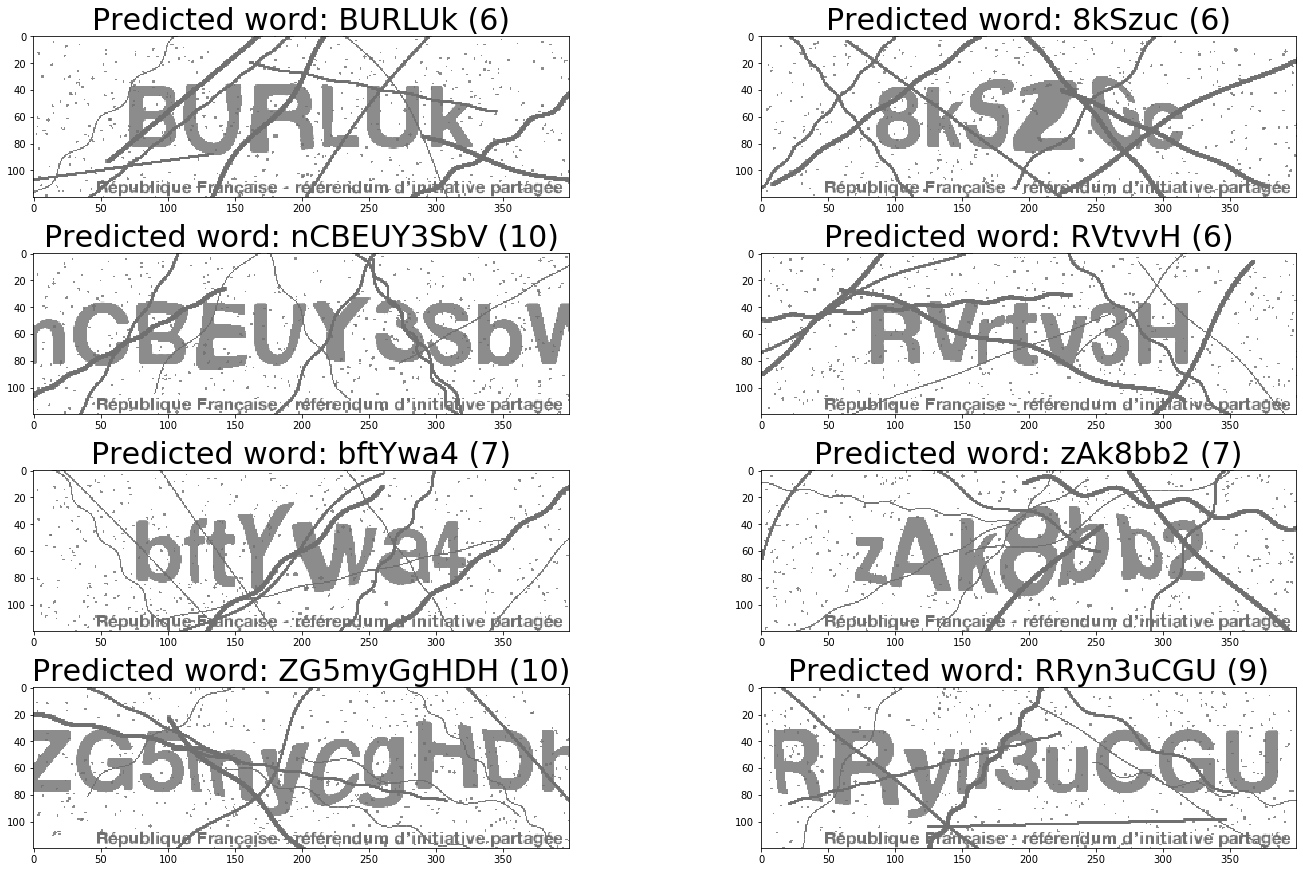

In [11]:
# Plot the images with the predicted words.
size = 3
ncols = 2
nrows = batch_size // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, ax in zip(images, words, axs):
  ax.imshow(image)
  text = f'Predicted word: {word} ({len(word)})'
  ax.set_title(text, fontsize=30)